In [1]:
import numpy as np
import matplotlib.pyplot as plt
from ML_for_GreenImaging.PipelineStages import *
from tensorflow.keras import models, optimizers, layers

2023-07-07 10:53:16.655857: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
def architecture_1(input_shape, n_filters, filter_size):
    network = models.Sequential()
    network.add(layers.Input(shape=(*input_shape, 1)))
    network.add(layers.Conv2D(n_filters[0], filter_size[0], strides=1, activation='relu'))
    network.add(layers.Conv2D(n_filters[1], filter_size[1], strides=1, activation='relu'))
    network.add(layers.Flatten())
    network.add(layers.Dense(2, activation='sigmoid'))
    return network

In [3]:
path = "/Users/jackmango/Desktop/QUIRP - Work/Princeton/Data/06:23:23/imaging exposure time = 30ms"
model = models.load_model(path + "/model1.h5")

In [4]:
loader = Loader.Loader(20, 100, path)
stack, tot_loops, info = loader.run()

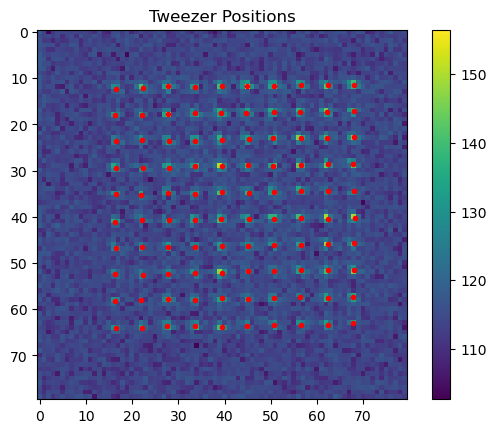

In [5]:
processor = ImageProcessing.ImageProcessor(stack, 100, tot_loops)
crops3x3, crops1x1, positions, info = processor.run()

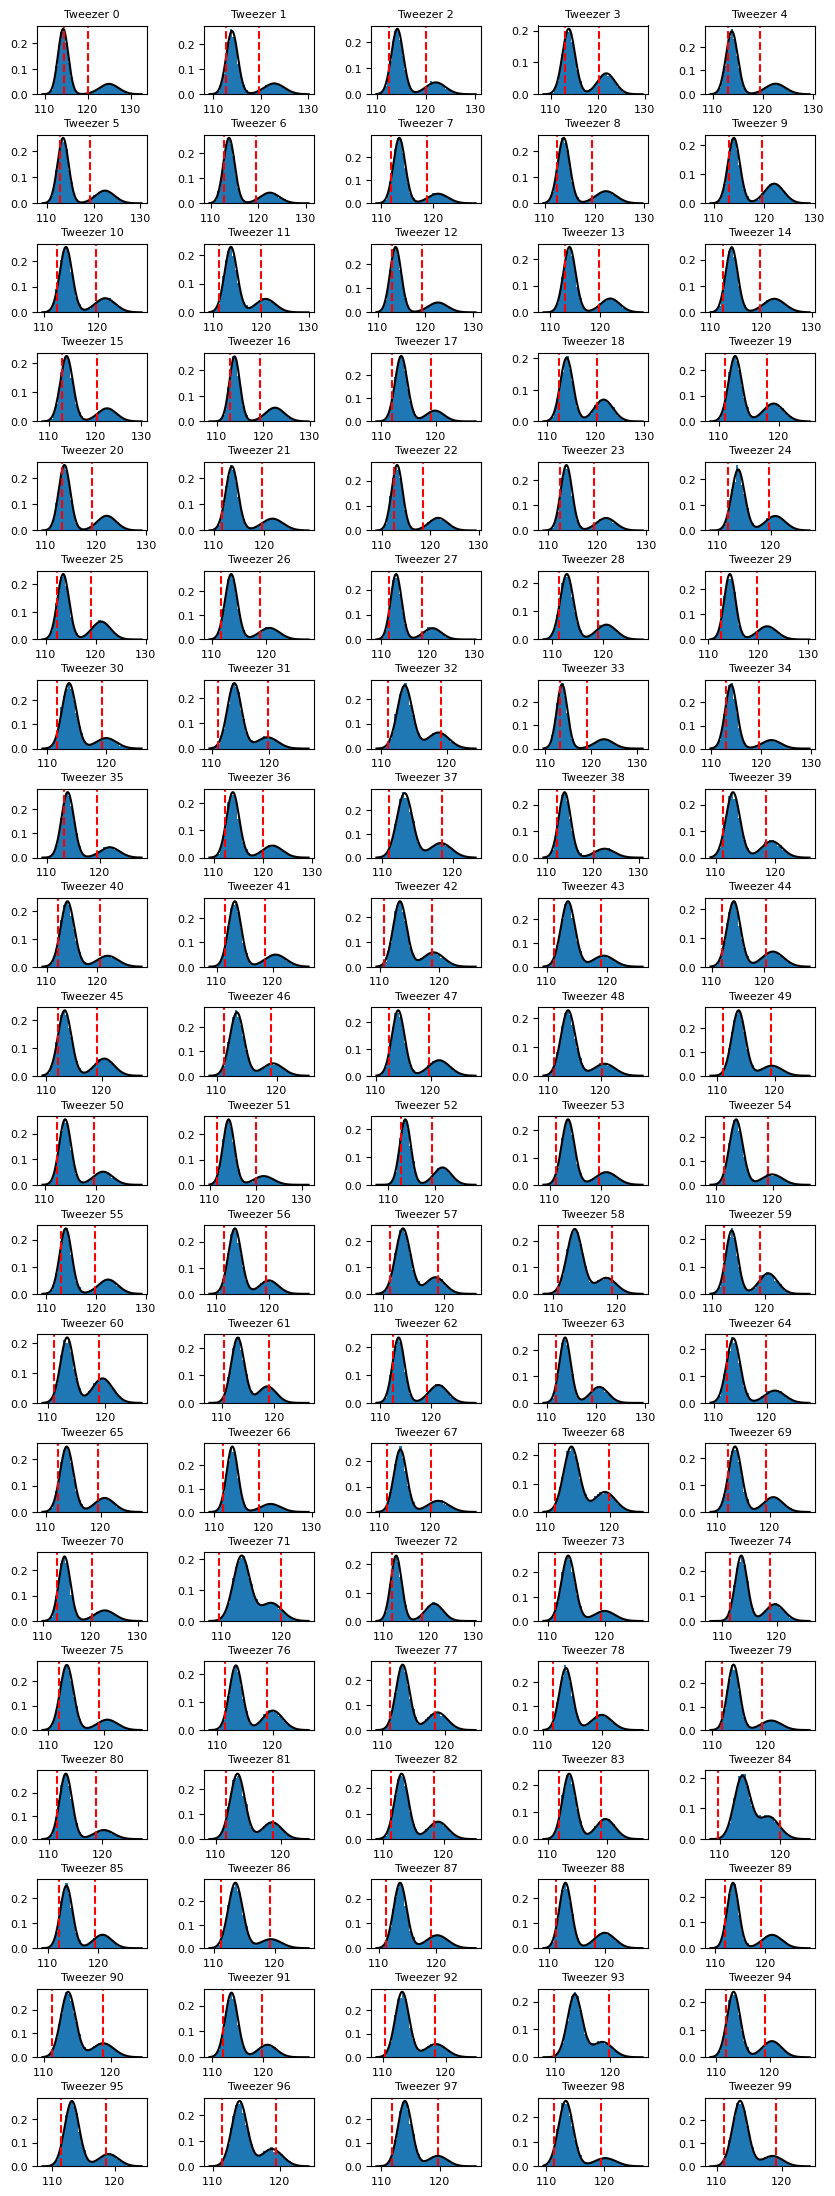

In [6]:
labeler = Labeler.Labeler(crops1x1, 100, tot_loops)
labels, info = labeler.run()

In [7]:
# Separate labels and crops for each site
crops3x3 = np.reshape(crops3x3, (100, *crops3x3.shape[1:]))
labels = np.transpose(np.array([np.absolute(labels - 1), labels]))
labels = np.reshape(labels, (100, -1, 2))
bad = np.isnan(labels)
keep = ~ bad
labels = [site_labels[site_keep[:, 0]] for site_labels, site_keep in zip(labels, keep)]
crops = [site_crops[site_keep[:, 0]] for site_crops, site_keep in zip(crops3x3, keep)]

In [8]:
# Randomly select 10% of each dataset for evaluation
testing = []
training = []
for tweezer_labels, tweezer_crops in zip(labels, crops):
    testing_indices = np.random.choice(tweezer_labels.shape[0], int(0.1 * tweezer_labels.shape[0]), replace=False)
    testing.append([tweezer_crops[testing_indices], tweezer_labels[testing_indices]])
    training.append([np.delete(tweezer_crops, testing_indices, axis=0), np.delete(tweezer_labels, testing_indices, axis=0)])

In [9]:
base_training_crops = np.concatenate([training[i][0] for i in range(100)])
base_training_labels = np.concatenate([training[i][1] for i in range(100)])
base_testing_crops = np.concatenate([testing[i][0] for i in range(100)])
base_testing_labels = np.concatenate([testing[i][1] for i in range(100)])

In [10]:
# Create base network to train for 4 epochs
model = architecture_1(crops3x3.shape[2:], [10, 10], [3, 3])
model.compile(optimizer=optimizers.Adam(learning_rate=1e-4), loss='binary_crossentropy', metrics=['binary_accuracy'])

In [11]:
# Train base model
model.fit(base_training_crops, base_training_labels, epochs=4)

Epoch 1/4
34346/34346 [==============================] - 149s 4ms/step - loss: 0.0225 - binary_accuracy: 0.9947
Epoch 2/4
34346/34346 [==============================] - 148s 4ms/step - loss: 0.0099 - binary_accuracy: 0.9984
Epoch 3/4
34346/34346 [==============================] - 147s 4ms/step - loss: 0.0090 - binary_accuracy: 0.9985
Epoch 4/4
34346/34346 [==============================] - 147s 4ms/step - loss: 0.0084 - binary_accuracy: 0.9986


48750/48750 [==============================] - 65s 1ms/step


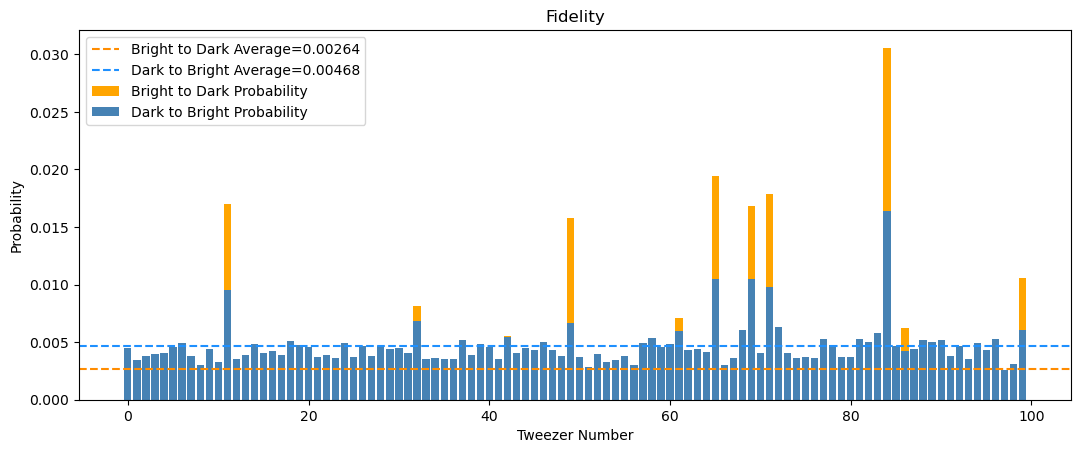

In [15]:
trainer = ModelTrainer.ModelTrainer(model, (base_training_crops, base_training_labels), (base_testing_crops, base_testing_labels), np.reshape(crops3x3, (-1, *crops3x3.shape[2:])), 100, tot_loops, epochs=8)
#model, info = trainer.run()
info = trainer.fidelity_analysis(trainer.n_tweezers, trainer.n_loops)
model.save(path + '/model1.h5')

In [16]:
# Create 100 NN's
networks = [models.load_model(path + '/model1.h5') for i in range(100)]
histories = []
test_accuracy = []

In [17]:
for i, tweezer_network in enumerate(networks):
    print(f"Tweezer {i}")
    tweezer_network.compile(optimizer=optimizers.Adam(learning_rate=1e-4), loss='binary_crossentropy', metrics=['binary_accuracy'])
    histories.append(tweezer_network.fit(*training[i], epochs=4))
    test_accuracy.append(tweezer_network.evaluate(*testing[i])[1])

Tweezer 0
Epoch 1/4
431/431 [==============================] - 3s 5ms/step - loss: 0.0025 - binary_accuracy: 0.9996
Epoch 2/4
431/431 [==============================] - 2s 5ms/step - loss: 0.0014 - binary_accuracy: 0.9997
Epoch 3/4
431/431 [==============================] - 2s 5ms/step - loss: 9.3656e-04 - binary_accuracy: 0.9997
Epoch 4/4
48/48 [==============================] - 0s 2ms/step - loss: 2.8803e-04 - binary_accuracy: 1.0000
Tweezer 1
Epoch 1/4
397/397 [==============================] - 3s 5ms/step - loss: 2.4876e-04 - binary_accuracy: 0.9999
Epoch 2/4
397/397 [==============================] - 2s 5ms/step - loss: 4.0941e-05 - binary_accuracy: 1.0000
Epoch 3/4
397/397 [==============================] - 2s 5ms/step - loss: 3.1686e-05 - binary_accuracy: 1.0000
Epoch 4/4
45/45 [==============================] - 0s 2ms/step - loss: 5.3805e-07 - binary_accuracy: 1.0000
Tweezer 2
Epoch 1/4
376/376 [==============================] - 2s 5ms/step - loss: 1.6264e-04 - binary_accuracy:

In [20]:
p_db = []
p_bd = []
for i, (network, crops) in enumerate(zip(networks, crops3x3)):
    print(f"Tweezer Number {i}")
    occ = np.argmax(network.predict(crops), axis=1)
    occ = np.reshape(occ, (tot_loops, -1))
    diff = np.diff(occ, axis=1)
    n_dark_to_bright = np.sum(diff == -1)
    n_dark = np.sum(occ[:,:-1] == 0)
    n_bright_to_dark = np.sum(diff == 1)
    n_bright = np.sum(occ[:,:-1] == 1)
    p_db.append(n_dark_to_bright / n_dark)
    p_bd.append(n_bright_to_dark / n_bright)

Tweezer Number 0
  1/488 [..............................] - ETA: 9s

488/488 [==============================] - 1s 2ms/step
Tweezer Number 1
488/488 [==============================] - 1s 1ms/step
Tweezer Number 2
488/488 [==============================] - 1s 1ms/step
Tweezer Number 3
488/488 [==============================] - 1s 1ms/step
Tweezer Number 4
488/488 [==============================] - 1s 1ms/step
Tweezer Number 5
488/488 [==============================] - 1s 1ms/step
Tweezer Number 6
488/488 [==============================] - 1s 1ms/step
Tweezer Number 7
488/488 [==============================] - 1s 1ms/step
Tweezer Number 8
488/488 [==============================] - 1s 1ms/step
Tweezer Number 9
488/488 [==============================] - 1s 1ms/step
Tweezer Number 10
488/488 [==============================] - 1s 1ms/step
Tweezer Number 11
488/488 [==============================] - 1s 1ms/step
Tweezer Number 12
488/488 [==============================] - 1s 1ms/step
Tweezer Number 13
488/488 [==============================] - 1s 1ms/step
Tweez

In [21]:
p_db = np.array(p_db)
p_bd = np.array(p_bd)

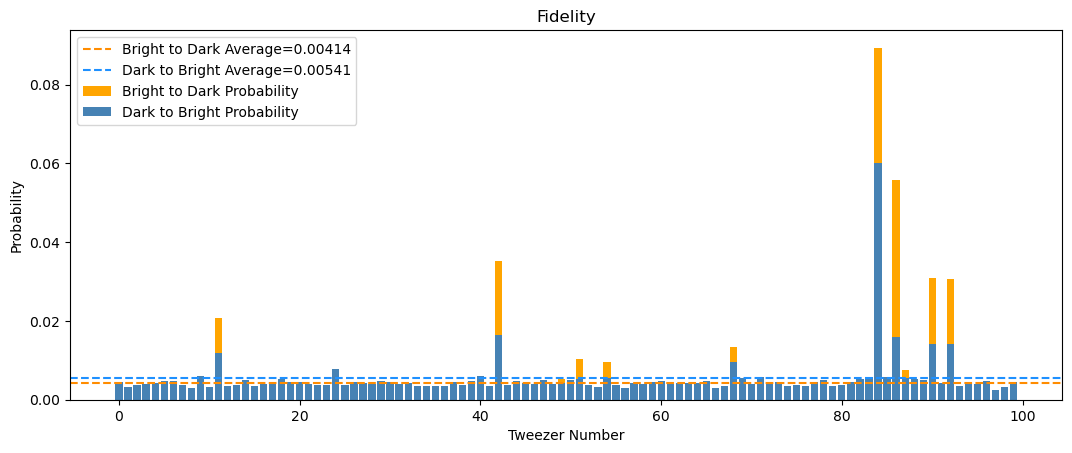

<Figure size 640x480 with 0 Axes>

In [23]:
plt.figure(figsize=(12.8, 4.8))
plt.bar(np.arange(100), p_bd, label=f'Bright to Dark Probability', color='orange')
plt.bar(np.arange(100), p_db, label=f'Dark to Bright Probability', color='steelblue')
plt.axhline(p_bd.mean(), label=f"Bright to Dark Average={np.mean(p_bd):.3}", color='darkorange', linestyle='--')
plt.axhline(p_db.mean(), label=f"Dark to Bright Average={np.mean(p_db):.3}", color='dodgerblue', linestyle='--')
plt.xlabel('Tweezer Number')
plt.ylabel('Probability')
plt.legend(loc='upper left')
plt.title('Fidelity')
plt.show()
plt.savefig(path + "/figure2.png")

In [ ]:
print(np.sum(labels[92], axis=0))

[4944. 3572.]


In [ ]:
networks[0].summary()

Model: "sequential_500"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1000 (Conv2D)        (None, 14, 14, 10)        100       
                                                                 
 conv2d_1001 (Conv2D)        (None, 12, 12, 10)        910       
                                                                 
 flatten_500 (Flatten)       (None, 1440)              0         
                                                                 
 dense_500 (Dense)           (None, 2)                 2882      
                                                                 
Total params: 3,892
Trainable params: 3,892
Non-trainable params: 0
_________________________________________________________________


In [ ]:
for i, network in enumerate(networks):
    network.save(f"tiny_networks/tiny_network_{i}.h5")

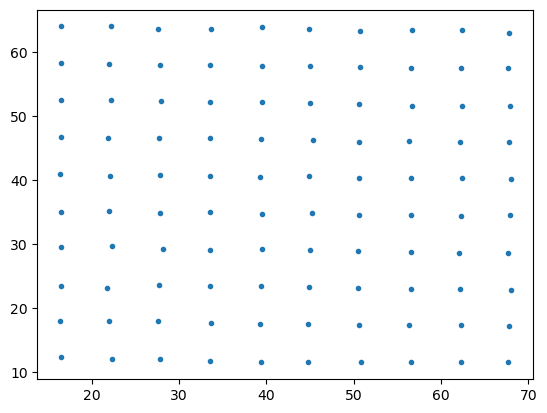

In [ ]:
im = plt.plot(*positions.T, '.')

In [ ]:
\

In [32]:
import numpy as np

def separate_vectors_by_tile(vectors, grid_size, tile_size):
    """
    Separate vectors into groups based on the square tiles they fall into.

    Parameters:
    - vectors: Array-like object containing the vectors.
    - grid_size: Tuple specifying the size of the 2D grid (e.g., (10, 10) for a 10x10 grid).
    - tile_size: Integer specifying the side length of the square tiles.

    Returns:
    - sorted_vectors: Sorted numpy array of vectors based on the tile number.
    """
    tile_indices = np.floor(vectors / tile_size).astype(int)
    tile_numbers = tile_indices[:, 1] * (grid_size[0] // tile_size) + tile_indices[:, 0]
    sorted_indices = np.argsort(tile_numbers)
    sorted_vectors = vectors[sorted_indices]
    
    return sorted_vectors


/var/folders/2f/l2325khj6r1d2csvqvdf7v280000gn/T/ipykernel_92778/2040543827.py:15: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  color_map = plt.cm.get_cmap('cool', len(sorted_vectors))


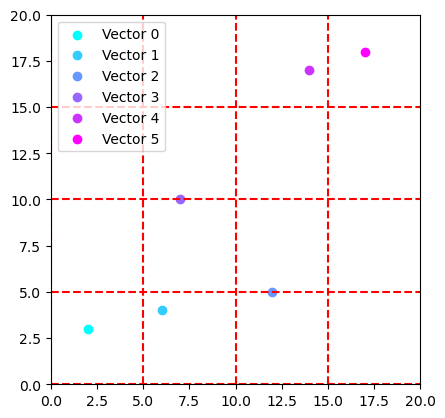

In [36]:
# Example usage
vectors = np.array([[2, 3], [12, 5], [7, 10], [6, 4], [17, 18], [14, 17]])
grid_size = (20, 20)
tile_size = 5

sorted_vectors = separate_vectors_by_tile(vectors, grid_size, tile_size)

# Plotting the sorted vectors
fig, ax = plt.subplots()
ax.set_xlim(0, grid_size[0])
ax.set_ylim(0, grid_size[1])
ax.set_aspect('equal')

# Create a color map based on the order of the vectors
color_map = plt.cm.get_cmap('cool', len(sorted_vectors))

# Plot the sorted vectors with color-coded markers
for i, vector in enumerate(sorted_vectors):
    ax.scatter(vector[0], vector[1], color=color_map(i), label=f'Vector {i}')

# Plot the tile boundaries
for x in range(0, grid_size[0], tile_size):
    ax.axvline(x, color='red', linestyle='--')
for y in range(0, grid_size[1], tile_size):
    ax.axhline(y, color='red', linestyle='--')

plt.legend()
plt.show()

In [31]:
print(groups)

{0: [array([2, 3])], 6: [array([12,  5])], 9: [array([ 7, 10])], 1: [array([6, 4])], 15: [array([17, 18])], 14: [array([14, 17])]}
